In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle
import utils.defects as defects
import nematic_env
import h5py

from torch.utils.tensorboard import SummaryWriter
from kinetic_solver import KineticData

In [7]:

with h5py.File('/home/hou63/pj2/Nematic_RL/log_ucsd/PPO_14/data_dump.h5', 'r') as f:
    # 获取并打印所有顶层键
    keys = list(f.keys())
    print("Keys in the HDF5 file:", keys)

Keys in the HDF5 file: ['Bm1_h', 'psi_h', 'psim1_h', 'simu_args', 'u_h', 'v_h']


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

path = '/home/hou63/pj2/Nematic_RL/log_ucsd/test_data/data_dump.h5'
with h5py.File(path, 'r') as f:
    psi_h = torch.tensor(f['psi_h'][:], dtype=torch.complex128, device=device)
    psim1_h = torch.tensor(f['psim1_h'][:], dtype=torch.complex128, device=device)
    u_h = torch.tensor(f['u_h'][:], dtype=torch.complex128, device=device)
    v_h = torch.tensor(f['v_h'][:], dtype=torch.complex128, device=device)
    Bm1_h = torch.tensor(f['Bm1_h'][:], dtype=torch.complex128, device=device)
    simu_args = f['simu_args'][:]

print(simu_args)
test_data = KineticData(psi_h, psim1_h, u_h, v_h, Bm1_h, simu_args)
test_data.to_device(device)
print(test_data.psi_h.shape)


[2.56000000e+02 2.56000000e+02 2.00000000e+01 6.28318531e+00
 7.81250000e-02 2.45436926e-02 4.00000000e-04 1.23400000e+03]
torch.Size([256, 256, 256])


In [2]:
def _action2light(self_intensity, device, action, grid_size=256):
    action = np.clip(action, -1, 1)
    # 确保 action 在 GPU 上是 PyTorch 张量
    if not isinstance(action, torch.Tensor):
        action = torch.tensor(action, device=device)
    
    # 1. 计算椭圆的参数
    x_center = ((action[0] + 1) / 2 * grid_size).int()  # 椭圆平移后的中心x坐标
    y_center = ((action[1] + 1) / 2 * grid_size).int()  # 椭圆平移后的中心y坐标
    a = (action[2] + 1) / 2 * grid_size / 2             # 长轴，假设范围是 [10, 60]
    b = (action[3] + 1) / 2 * grid_size / 2             # 短轴，假设范围是 [5, 35]
    theta = (action[4] + 1) / 2 * 2 * torch.pi          # 方向角范围 [0, 2π]
    intensity = (action[5] + 1) / 2 * self_intensity    # 光照强度范围 [0, intensity]

    # 2. 构建网格坐标，并以中心为原点放置椭圆
    y, x = torch.meshgrid(torch.arange(grid_size, device=device), torch.arange(grid_size, device=device))
    x_shifted = x - grid_size // 2  # 平移椭圆初始位置到正中心
    y_shifted = y - grid_size // 2

    # 3. 旋转椭圆的角度变换
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    # 旋转后的坐标
    x_rotated = x_shifted * cos_theta + y_shifted * sin_theta
    y_rotated = -x_shifted * sin_theta + y_shifted * cos_theta

    # 4. 椭圆方程，用于定义椭圆内的区域
    ellipse_mask = (x_rotated / (a + 1e-6))**2 + (y_rotated / (b + 1e-6))**2 <= 1

    # 5. 创建光照矩阵，初始值都设为1，表示椭圆外部区域
    light_matrix = torch.ones((grid_size, grid_size), device=device)

    # 6. 渐变效果 - 根据椭圆边缘距离生成，椭圆内从1到指定强度渐变
    distance = torch.sqrt((x_rotated / (a + 1e-6))**2 + (y_rotated / (b + 1e-6))**2)
    light_matrix_centered = torch.where(ellipse_mask, intensity - (intensity - 1) * distance, light_matrix)

    # 7. 将光照矩阵平移到指定的中心位置
    x_translation = (x_center - grid_size // 2) % grid_size
    y_translation = (y_center - grid_size // 2) % grid_size

    # 8. 使用 roll 函数将矩阵平移并处理周期性边界条件
    light_matrix_shifted = torch.roll(light_matrix_centered, shifts=(y_translation.item(), x_translation.item()), dims=(0, 1))
    # light_matrix_shifted = torch.ones((grid_size, grid_size), device=device)
    return light_matrix_shifted

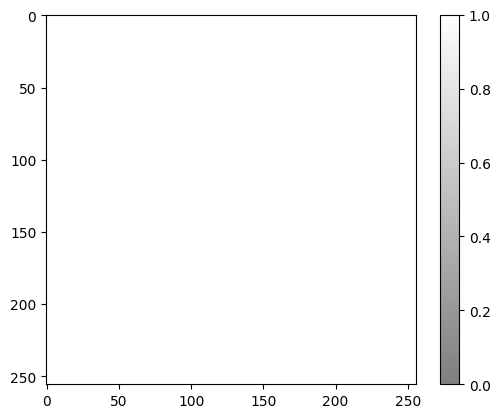

In [6]:
# writer for img saving
action = [0.5, -1.5, -0.86, -1.45, -2.58, -2.9]
action = np.clip(action, -1, 1)
action_mat = _action2light(10, torch.device('cpu'), action)
fig, ax = plt.subplots()
fig.colorbar(ax.imshow(action_mat, cmap='gray', alpha=0.5))
plt.show()